In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F

# A Transformers Deep Dive

## by Daniel Mendelevitch

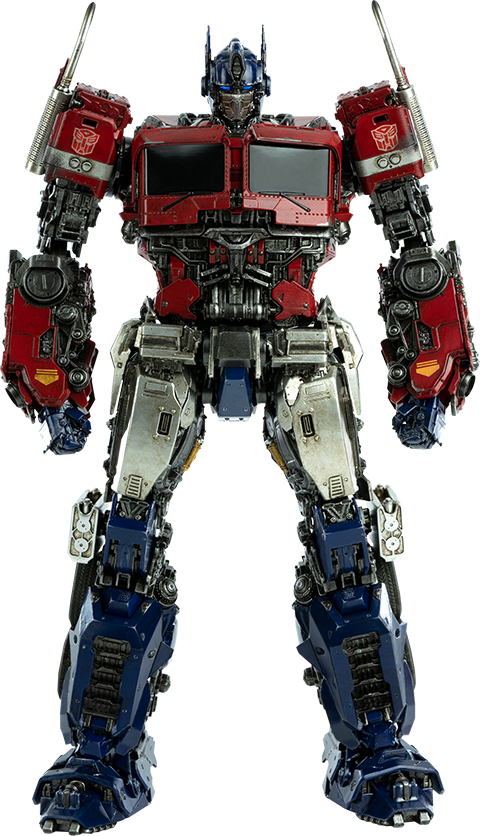

# Introduction

Hi! This is a notebook designed to explain one of the most important concepts in contemporary Deep Learning: [The Transformer](https://arxiv.org/abs/1706.03762?context=cs). It's designed for people with some familiarity with how regular [Neural Networks](https://https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf) work, as well as some python experience and some PyTorch experience. By the end of this, the hope is that you have a better understanding of the mechanics, computation, and intuition underlying some of the most powerful statistical models ever devised. The following section will introduce some basic context, and then we'll dive right into the dirty details of transformers.

## Super Duper Brief Torch Primer

**If you have PyTorch experience, skip this!!!**

For those with less Torch experience, note that this notebook is written almost entirely in Torch. In an effort to make the code as accessible as possible, here is what you need to know about Torch to understand this notebook:

### Tensors

In [2]:
x = torch.Tensor([1,2,3])
x

tensor([1., 2., 3.])

Tensors are the fundamental building block of PyTorch. They function super similarly to numpy arrays. They're meant to be an effective and efficient way of storing multidimensional data, and they also allow Torch to do backprop and compute gradients easily.

In [3]:
x.shape

torch.Size([3])

Every tensor has a *shape*. A tensor's shape describes its dimensionality. In the above case, *x* has a shape of 3 since it just has 1 dimension and 3 elements.

In [4]:
y = torch.tensor([[1,2,3], [4,5,6]])
y.shape

torch.Size([2, 3])

The above tensor has a shape of (2, 3) or "2 by 3" since it has 2 rows and 3 columns of information (i.e. it has 2 lists of 3 elements). You can think of a tensor with a shape of (m, n) with positive nonzero integers m, n as a matrix. 

In [5]:
z = torch.tensor([[[1,2,3], [4,5,6]] for i in range(10)])
z.shape

torch.Size([10, 2, 3])

The above tensor has 3 dimensions: 10 x 2 x 3. You can think of this as a 3 dimensional stack of 2x3 matrices, i.e. we have 10 2-dimensional matrices. When processing data in *batches* (i.e. processing multiple data points at a time), we often encounter 3 (or even higher) dimensional tensors.

### Matrix Products: `@`

In [6]:
a = torch.randn(10, 20) # torch.randn is torch's random normal function: it gives you a random normal sample of the specified shape
b = torch.randn(20, 10)

product = a @ b # matrix multiply a and b
product.shape

torch.Size([10, 10])

The `@` symbol in pytorch is shorthand for a matrix product. You can basically think of it as a more generalized version of matrix multiplication, as it also functions as a dot product (and a matrix multiplication for certain axes of higher dimensional tensors). There is a dedicated torch function to do this as well, but I think the `@` is cooler so I'll be using it throughout this notebook.

In [7]:
product2 = torch.matmul(a, b)
product == product2 # every element of product1 is equal to every element of product2

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

### nn.`____`

Torch has tons of useful helpers function for specific Neural Network related layers and math. They're all stored in the torch.nn module. In this notebook, we'll be using a few, but most notably the `torch.nn.Linear`, or just `nn.Linear` layer. `nn.Linear` functions essentially like a connection between two hidden layers in a vanilla Neural Network (or a Dense layer in Keras for those familiar). You can think of it as holding a matrix which linearly transforms some data in a specified input dimension to some output dimension.

In [8]:
linear = nn.Linear(7, 5) # transforms 7 dimensional data to 5 dimensional. We run this transformation by "calling" the layer, i.e. linear(data)

data = torch.randn(7)
data.shape

torch.Size([7])

In [9]:
transformed = linear(data)
transformed.shape

torch.Size([5])

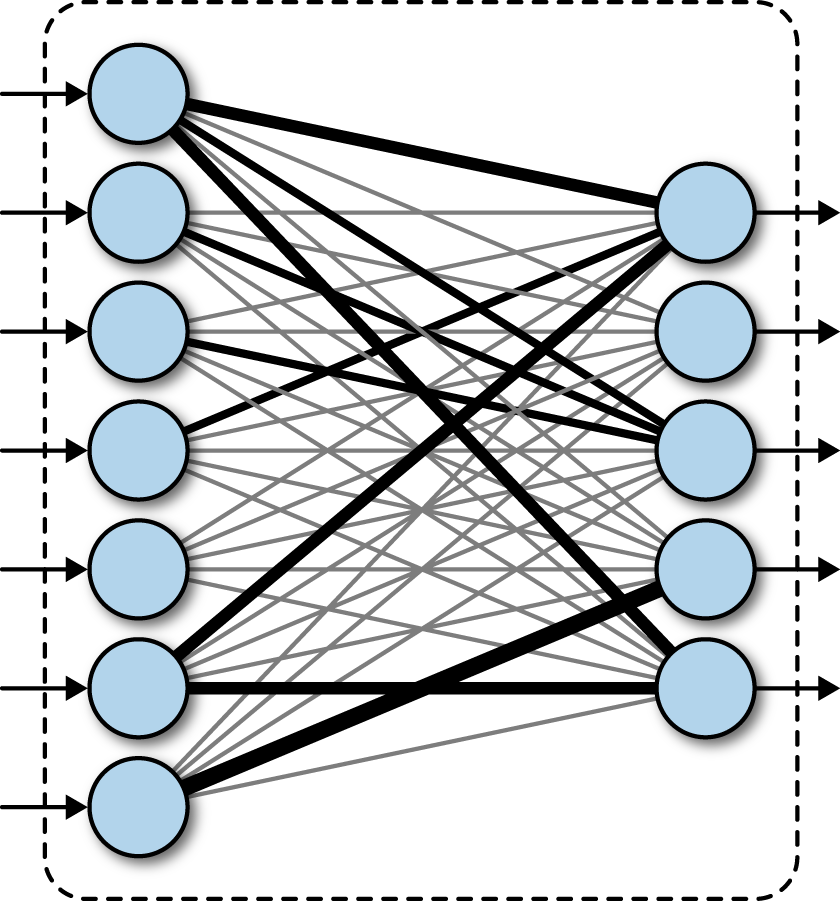

## What is Language Modeling?

The term "language model" is often ambiguous and can mean a variety of things. In the context of this notebook, though, language modeling will refer to **the process of making inferences and statistical modeling using language data**.

Examples of language models of this kind are things like OpenAI's GPT-3, which has leveraged terabytes of text data to "learn" how to complete given input phrases. For example, if I prompt GPT-3 with: "Hi GPT! How are you today?", GPT-3 will generate a response it thinks is *likely* given all the text it's been trained on.

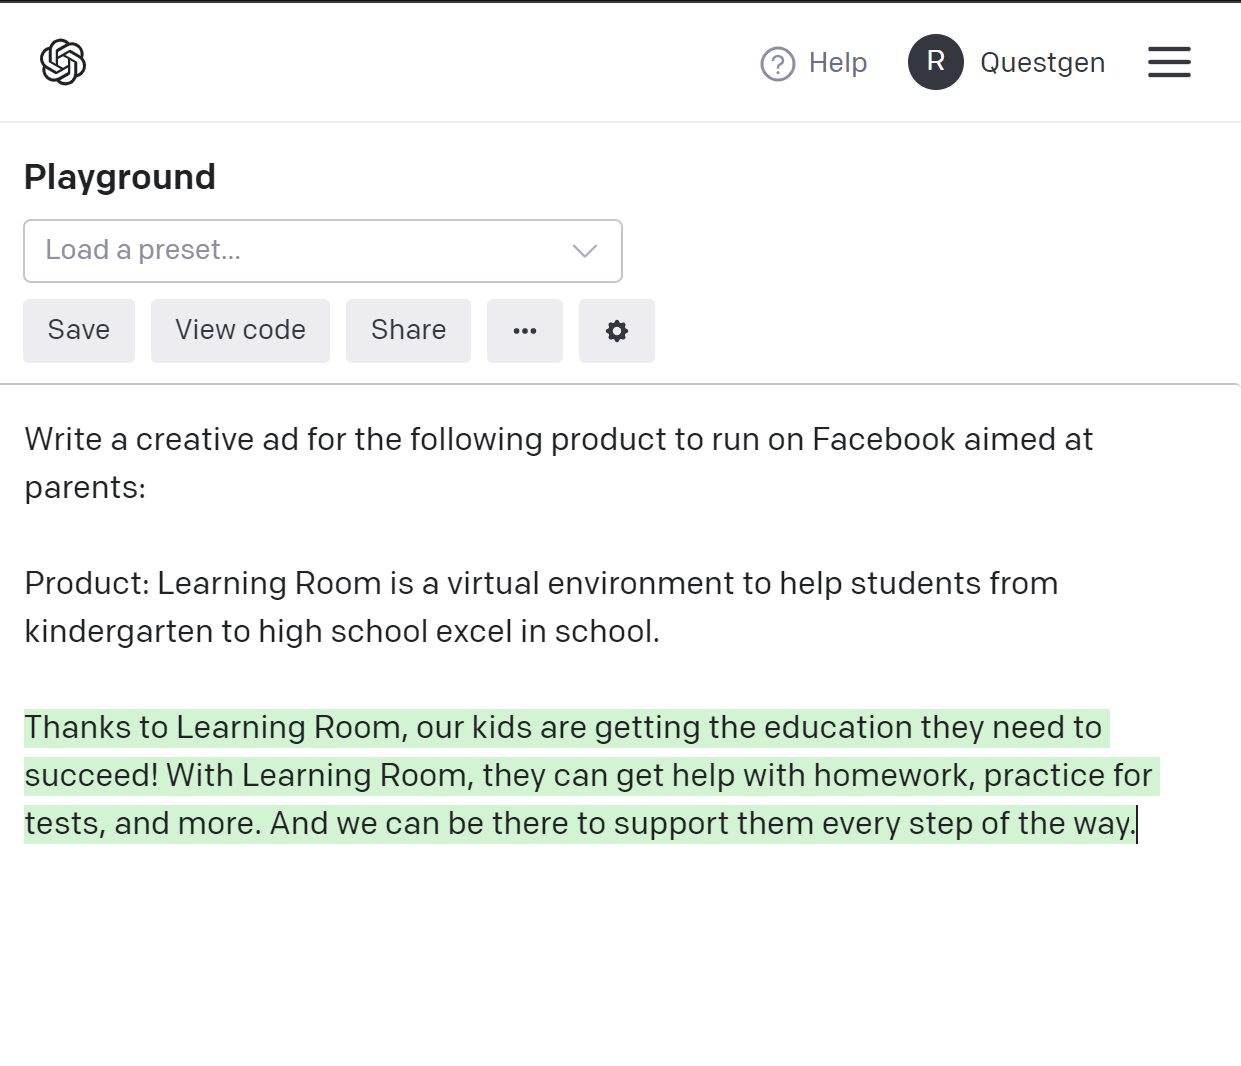

The above image is a real text generation from GPT-3 (human-written prompt is not highlighted, GPT-3's response is highlighted in green).

GPT-3's underlying training task is simple: given a sequence of input words (or *tokens*), predict the most likely *next* token. What GPT-3 then does is it feeds the entire input sequence AND its predicted token back into itself as an input, and once again tries to predict the next token.

As you can see, these models are able to generate some pretty convincing outputs. Language Modeling has only recently been able to achieve such high performance, thanks to the Transformer architecture.

But this begs the question: how do they work?

# Part 1: Tokenization

## How do neural networks deal with language?

To understand how words are processed by Neural Networks (and Transformers), we need to introduce the concept of *tokenization*. 

Because Neural Networks only work with numeric data, if we want to pass words into Neural Networks as inputs, we need to find a suitable numeric representation of language data. In essence, we need to convert words to numbers somehow.

A naive way to convert words to numbers is to assign every word in the english language an integer, i.e. "the" is 1, "and" is 2, and so on.

In [10]:
mapping = {"hi": 1, "there": 2, "really": 3, "nice": 4, "to": 5, "meet": 6, "you": 7, "<START>": 8, "<END>": 9} # map each token to some ID

test_phrase = '<START> hi there really nice to meet you <END>'

tokenized = [mapping[i] for i in test_phrase.split(' ')]
tokenized

[8, 1, 2, 3, 4, 5, 6, 7, 9]

In the above example, I only assigned an integer to each word in the sentence I wanted to construct, but you can imagine a scheme which each word in english is assigned a number. We also assign two special tokens a number: a start and end token. These help with language generation tasks, as if a model is creating brand new text, it can indicate when it wants to end its text generation.

This process of converting language to numbers is called "tokenization", and is standard practice in almost every NLP task. In practice, many LLMs leverage a slightly better encoding scheme called BPE (Byte-Pair Encoding), which uses Information Theory to determine which *subwords* are most frequent, and assigns them IDs as opposed to just using entire words.

In [11]:
!pip install tokenizers

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [12]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_pretrained("bert-base-cased")
encoded = tokenizer.encode("hi there really nice to meet you") # tokenize our input sentence using a pretrained encoder from the Huggingface Tokenizers library
print(f'Tokenized ids: {encoded.ids}')
print(f'Encoded tokens: {encoded.tokens}')

Tokenized ids: [101, 20844, 1175, 1541, 3505, 1106, 2283, 1128, 102]
Encoded tokens: ['[CLS]', 'hi', 'there', 'really', 'nice', 'to', 'meet', 'you', '[SEP]']


Above is an actual tokenizer used in an LLM called "BERT" (more on BERT later).

Notice that with differing length sentences, the number of toknized IDs we have can change dramatically.

In [13]:
ids = tokenizer.encode("I'd rather not take Math 32A if I don't have to -- it just seems like such a boring class.").ids
len(ids)

29

In [14]:
ids = tokenizer.encode("DSU is awesome").ids
len(ids)

6

With Neural Networks, we generally expect a *fixed* input size, i.e. each time we run the network, we always need to recieve the same # of tokens. With varying tokenized sentence length, how do we make sure input sequences fit into the Neural Network?

We use something called "padding." If we need every sequence of tokens to have, say, 1024 elements (this is a common max sequence length), we first encode our input text and then add 0s or some useless number to the sequence until we hit our desired length. Note that if our sequence is *longer* than our intended sequence length, we often times *truncate* a sequence to the desired length.

In [15]:
seq_len = 1024
tokenizer.enable_padding(pad_id=0, pad_token="[PAD]", length=seq_len)

In [16]:
ids = tokenizer.encode("I'd rather not take Math 32A if I don't have to -- it just seems like such a boring class.").ids
len(ids)

1024

In [17]:
ids = tokenizer.encode("DSU is awesome").ids
len(ids)

1024

## Embedding our tokens

Ok, cool. We have turned our words to numbers. Everything's ready to feed into our Neural Network, right?

Not quite.

Self-attention, the mechanism which powers Transformers, requires a sequence of *vectors* to work, not a sequence of integers. We need to find a way to convert our integers to vectors.

To deal with this, we add an extra "embedding" layer which essentially converts each token into a vector. With the embedding layer, we're able to convert a sequence of words to a sequence of vectors. 

Note that this embedding layer is actually a part of our Neural Network, and its weights will change as our Neural Network learns.

In [18]:
vocab_size = len(tokenizer.get_vocab())
vocab_size

28996

In [19]:
# our neural network will process vectors with 512 components for this example
input_dim = 512 

In [20]:
# initiate a layer with random vectors which correspond to each word in the vocabulary
# this means that we have 28996 x 512 vectors in this layer, or a Matrix with dimensions vocab_size x input_dim
emb = nn.Embedding(vocab_size, input_dim) 

Quick sidenote: `nn.Embedding` contains a *lookup table* of various vectors. In the above case, we've initialized the table to have `vocab_size` entries, with each entry being a vector with `input_dim` components. Then, if we pass an integer between 0 and `vocab_size`, this nn.Embedding layer will return the vector it has stored at that index.

In [21]:
# this is the vector corresponding to token ID 0
# as the Neural Network learns, this vector (and all other ones in this embedding layer) will change to better suit the training objective
emb(torch.tensor(0)).shape 

torch.Size([512])

In [22]:
# here we can pass a *tensor* of every ID at once into the embedding layer, and get a sequence of output vectors 
embeddings = emb(torch.tensor(ids)) 

In [23]:
# first 10 tokens as vectors. Note how the last 3 are all the same vector, as they correspond to padding
embeddings[0:10] 

tensor([[ 0.1786, -2.8018,  0.7512,  ...,  0.0429,  0.3153, -1.4967],
        [ 1.4671,  0.7155,  0.3560,  ...,  0.0843, -0.8807, -0.1905],
        [-0.9763,  0.4884, -1.3851,  ..., -0.7101, -0.9835, -1.4557],
        ...,
        [-1.0413, -1.5867,  0.8416,  ...,  1.3990, -1.3912,  0.1713],
        [-1.0413, -1.5867,  0.8416,  ...,  1.3990, -1.3912,  0.1713],
        [-1.0413, -1.5867,  0.8416,  ...,  1.3990, -1.3912,  0.1713]],
       grad_fn=<SliceBackward0>)

In [24]:
embeddings.shape # we've converted our sequence of integers of shape (1024,) to a sequence of vectors of shape (1024, 512)

torch.Size([1024, 512])

### Now our sequence of tokens is finally ready to be fed into the Neural Network... right?

# Part 2: Positional Encodings

Yes and no.

Sure, the data has been transformed into a way the Neural Network can understand it. Something's still missing from this representation of language as numbers: positional information.

Think of the problem of Natural Language Generation: a model would want to know *at what point in the sequence* they currently are, not just the word they're currently processing and its context. For that reason, we need to add extra information into our formulation. But how do we ensure that the model understands the *position* of each token in the sequence?

A naive approach is to add some scalar to each embedding based on the position. For example, we can add 0 to every component in the first vector, 1 to every component in the second vector, 2 to every component in the third vector, and so on.

## Naive Approach

In [25]:
n_components = 512
naive_positional_encodings = torch.tensor(
  [
    [i for _ in range(n_components)] 
    for i in range(seq_len)
  ]
)
naive_positional_encodings[0:5]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 2, 2, 2],
        [3, 3, 3,  ..., 3, 3, 3],
        [4, 4, 4,  ..., 4, 4, 4]])

In [26]:
positionally_encoded = embeddings + naive_positional_encodings
positionally_encoded[1, 0:10] # first 10 elements of new positionally encoded vector at position 1

tensor([ 2.4671,  1.7155,  1.3560,  1.0751,  1.2435,  0.2735,  0.1676,  2.8560,
         1.5242, -0.4928], grad_fn=<SliceBackward0>)

In [27]:
embeddings[1, 0:10] # notice that every value in this vector is 1 less than the positionally encoded version

tensor([ 1.4671,  0.7155,  0.3560,  0.0751,  0.2435, -0.7265, -0.8324,  1.8560,
         0.5242, -1.4928], grad_fn=<SliceBackward0>)

One problem with this strategy is that elements later in the sequence will have unreasonably high values, which might lead to super high magnitude gradients when we do gradient descent. It also doesn't allow the neural network to easily distinguish between what is padded and what isn't padded.

In [28]:
positionally_encoded[350,0:10] # this should correspond to padding, but it differs from every other padding token

tensor([348.9587, 348.4133, 350.8416, 350.1291, 350.2109, 350.8637, 351.4408,
        349.7350, 349.1215, 349.9916], grad_fn=<SliceBackward0>)

So instead of adding raw integers, we need to come up with a better way to encode positions. 

One possible better solution is to use a periodic function to encode our sequences, such as the function `sin(pos)`. That is to say, we can add `sin(1)` to each component of the vector in position 1, we can add `sin(2)` to each element in position 2, and so on.

## Less Naive Approach

In [29]:
slightly_better_pos_encoding = torch.tensor(
    [
      [np.sin(i) for _ in range(n_components)] # vectors of sin(1), sin(2), sin(3), etc
      for i in range(1, seq_len+1)
    ]
)

In [30]:
slightly_better_pos_encoding

tensor([[ 0.8415,  0.8415,  0.8415,  ...,  0.8415,  0.8415,  0.8415],
        [ 0.9093,  0.9093,  0.9093,  ...,  0.9093,  0.9093,  0.9093],
        [ 0.1411,  0.1411,  0.1411,  ...,  0.1411,  0.1411,  0.1411],
        ...,
        [-0.8318, -0.8318, -0.8318,  ..., -0.8318, -0.8318, -0.8318],
        [-0.9165, -0.9165, -0.9165,  ..., -0.9165, -0.9165, -0.9165],
        [-0.1585, -0.1585, -0.1585,  ..., -0.1585, -0.1585, -0.1585]],
       dtype=torch.float64)

In [31]:
slightly_better_positionally_encoded = embeddings + slightly_better_pos_encoding
slightly_better_positionally_encoded[0, 0:10] # first 10 elements of new positionally encoded vector

tensor([ 1.0201, -1.9603,  1.5927,  0.5785,  0.7134,  0.3747,  2.6020, -0.2085,
         2.1451,  0.0699], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [32]:
slightly_better_positionally_encoded[350,0:10]

tensor([-1.7981, -2.3435,  0.0849, -0.6277, -0.5459,  0.1069,  0.6840, -1.0217,
        -1.6353, -0.7652], dtype=torch.float64, grad_fn=<SliceBackward0>)

As you can see, here we avoid the problem of having arbitrarily large numbers later in the sequence. However, this too still has issues. To understand this, let's plot our positional encoding function.

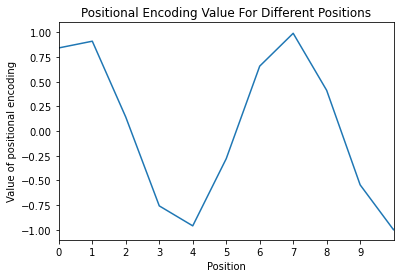

In [33]:
import matplotlib.pyplot as plt
plt.xlim(0,10)
plt.xlabel("Position")
plt.ylabel("Value of positional encoding")
plt.xticks(range(10))
plt.title("Positional Encoding Value For Different Positions")
plt.plot(
    [np.sin(i) for i in range(1,seq_len+1)]
)

Notice how at positions 1 and 7, the positional encoding we add is almost identical, even though the two elements are in different places in the sequence. With any periodic function, this will be the case. Ideally, we want a positional encoding which modifies each vector in our sequence in some unique way to encode positional information -- if there's any repitition of position information, it might confuse our model.

## Transformer Positional Encodings

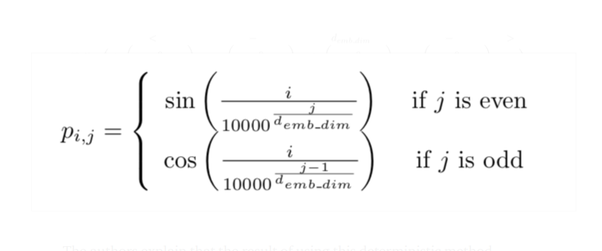

The above function is the positional encoding used in the original Transformer paper. In this function, *i* is the position of a vector in a sequence, *d_embed_dim* is its dimensionality, and *j* is the index/order of a specific component in its vector. What this means is that our positional encoding is a function of two variables: position and index.

To illustrate what this means, imagine the sequence of vectors (0,1,2) and (3,4,5)

Our positional encoding scheme would iterate through each vector *and* each  component in that vector, and add some number to that component based on the above formula.

For the vector (0,1,2), if we want to figure out how much we add to the first component (index 0) in the vector, we can just plug it into the formula: 

`PE(i=0, j=0) = sin(0/10000 ^ (0/2)) = sin(0) = 0.`

For the second component, we use a cosine curve:

`PE(i=0, j=1) = cos(0/10000 ^ (0/2)) = cos(0) = 1.`

And for the third, the result will be the same as the first, as we are at position 0, and sin(0/anything) = 0.

However, for pos=1 and greater, the positional encoding starts to become interesting.

`PE(i=1,j=0) = sin(1/10000^(0/2)) = sin(1) which is about 0.84`

`PE(i=1, j=1) = cos(1/10000^(0/2)) = cos(1/10000^0) which is about 0.54`

`PE (i=1, j=2) = sin(1/10000^(2/2)) = sin(1/10000^2) which is about 0`

Note how previously, each position had the same positional encoding for each index. But in this case, as the index varies, we get different positional encodings. This fixes our uniqueness problem. Let's verify that our math was right.


In [34]:
def PE(i, j, d=2):
  if j % 2 == 0:
    return np.sin(
        i / (
          np.power(10000, j/d)
        )
    )
  else:
    return np.cos(
        i / (
          np.power(10000, (j-1)/d)
        )
    )

In [35]:
for pos in range(2):
  for idx in range(3):
    print(f'PE ({pos}, {idx}) = {PE(pos, idx)}')

PE (0, 0) = 0.0
PE (0, 1) = 1.0
PE (0, 2) = 0.0
PE (1, 0) = 0.8414709848078965
PE (1, 1) = 0.5403023058681398
PE (1, 2) = 9.999999983333334e-05


The main idea behind this Positional Encoding is that now there isn't the same repetition as seen before with the naive sin(pos) encoding. Each index now has a unique value alongside the position of each vector, so the positional encoding is actually unique for each vector.

In [57]:
good_positional_encodings = torch.tensor(
  [
    [PE(i, j) for j in range(n_components)] 
    for i in range(seq_len)
  ]
)

PE_encoded = embeddings + good_positional_encodings

<ipython-input-34-97a186f8748a>:5: RuntimeWarning: overflow encountered in power
  np.power(10000, j/d)
<ipython-input-34-97a186f8748a>:11: RuntimeWarning: overflow encountered in power
  np.power(10000, (j-1)/d)


In [58]:
PE_encoded # note how our padding is no longer all uniform, the first components of the last 3 elements vary

tensor([[ 0.1786, -1.8018,  0.7512,  ...,  1.0429,  0.3153, -0.4967],
        [ 2.3086,  1.2558,  0.3561,  ...,  1.0843, -0.8807,  0.8095],
        [-0.0670,  0.0723, -1.3849,  ...,  0.2899, -0.9835, -0.4557],
        ...,
        [-1.0237, -2.5866,  0.9436,  ...,  2.3990, -1.3912,  1.1713],
        [-1.8732, -2.1418,  0.9437,  ...,  2.3990, -1.3912,  1.1713],
        [-1.9578, -1.1867,  0.9438,  ...,  2.3990, -1.3912,  1.1713]],
       dtype=torch.float64, grad_fn=<AddBackward0>)

We have now successfully added temporal information into our architeture!

# Part 3: Attention

## What is attention?

### Attention is a scalar. 

More specifically, attention is a scalar which we can use to determine whether or not two pieces of data are "compatible", or relate to each other in some meaningful way. Specifically in language, this can be interpreted as if one token describes or relates to another.

A commonly used function to determine attention is the dot product, as it has the nice geometric interpretation as being proportional to the angle between two vectors. That is to say, if we take two vectors with data and compute their dot product, we can get the attention between them. There are other ways to compute attention, but for this lesson we'll stick to the dot product.

Usually attention is used to compare a piece of data to a sequence, and we say that one piece of data is "attending" to each element in that sequence, as is seen in the diagram below. Darker red lines in that context represent one vector attending more strongly (i.e. higher dot product) than another.

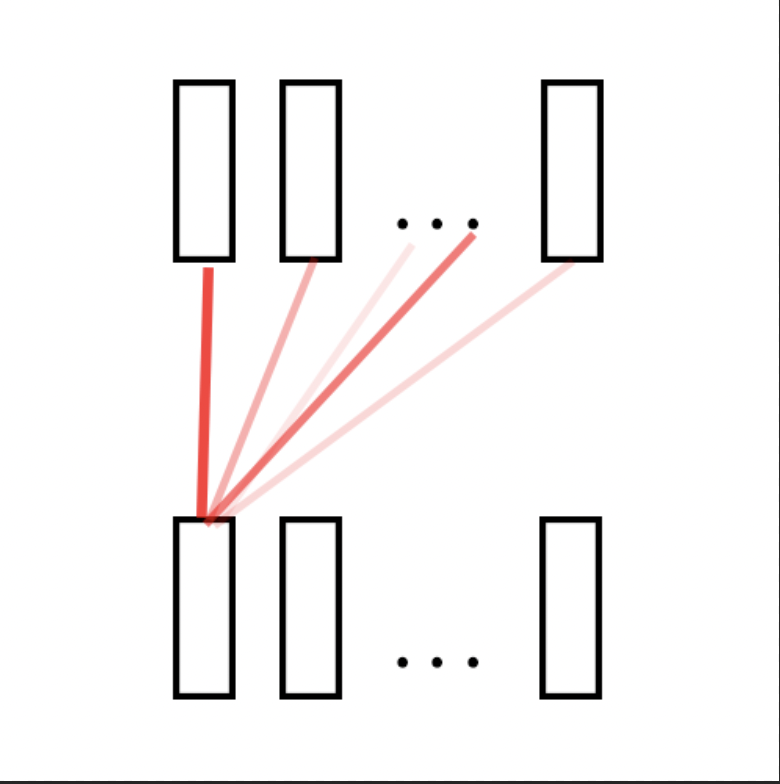

A quick warning:

One of the most confusing parts of Attention is the terminology used to describe it. 

When computing attention, we use two terms: a "query" describes the source of our attention, i.e. the vector which will be "attending" to every vector in our comparison sequence. That comparison sequence is referred to as the "keys". This will become much clearer later.

In [59]:
query_vec = torch.randn(10,) # create a random normal distributed vector with 10 components
print(f'Random query vec: \n{query_vec}')

key_vecs = torch.randn(5, 10) # create 5 random normal distributed vectors with 10 components
print(f'Random key vecs: \n{key_vecs}')

attention = query_vec @ key_vecs.T # compute the dot product between the query vector and each vector in key_vecs, and store the resulting attention in a tensor
print(f'Attention vector: \n{attention}')

Random query vec: 
tensor([ 0.3988, -0.6966,  0.8578, -0.7370,  0.0934,  1.3628, -0.2652,  1.3675,
         0.0168, -0.7758])
Random key vecs: 
tensor([[ 0.7567,  0.5165, -1.1346, -0.9676, -1.4342, -0.3843,  2.0650,  1.2715,
         -0.3608, -0.4623],
        [ 1.0999,  0.9476,  1.2045, -0.1950,  0.0899,  0.1372,  0.5029, -1.3858,
          1.2366,  0.3489],
        [ 0.0345, -0.6789, -1.2319,  1.9012,  1.1032,  2.1146,  0.7854, -0.0940,
          0.1136,  0.1929],
        [ 0.7610,  1.0899, -1.7111, -0.9572, -1.7282,  1.2207,  0.5412,  1.1382,
         -1.2311,  0.6131],
        [-0.3482,  0.4840,  0.7619,  2.2597, -0.6002,  0.5183, -0.4415, -0.5276,
         -0.3022,  0.8578]])
Attention vector: 
tensor([ 0.5678, -1.1276,  0.5287,  1.2006, -2.1126])


The first element of the attention vector above is the attention between our query and the first key, the second element is the attention between our query and the second key, and so on. Sometimes attention might be stored in a vector (or matrix), but always remember that this is just a nice way of aggregating our various scalar attentions.

In the above case with random vectors, the attention results are kind of meaningless. The above example was simply meant to illustrate the computation. But when we use real data points, the attention can be a useful way to quantify *how* much data points relate to one another.

Note the terminology of queries and keys, this will become important later.

## Attention in Practice

At this point you might be wondering: this is just a dot product, why is it so important? What are the actual vectors that are actually attended to? 

Let's look at an example of attention with an actual sentence in English:

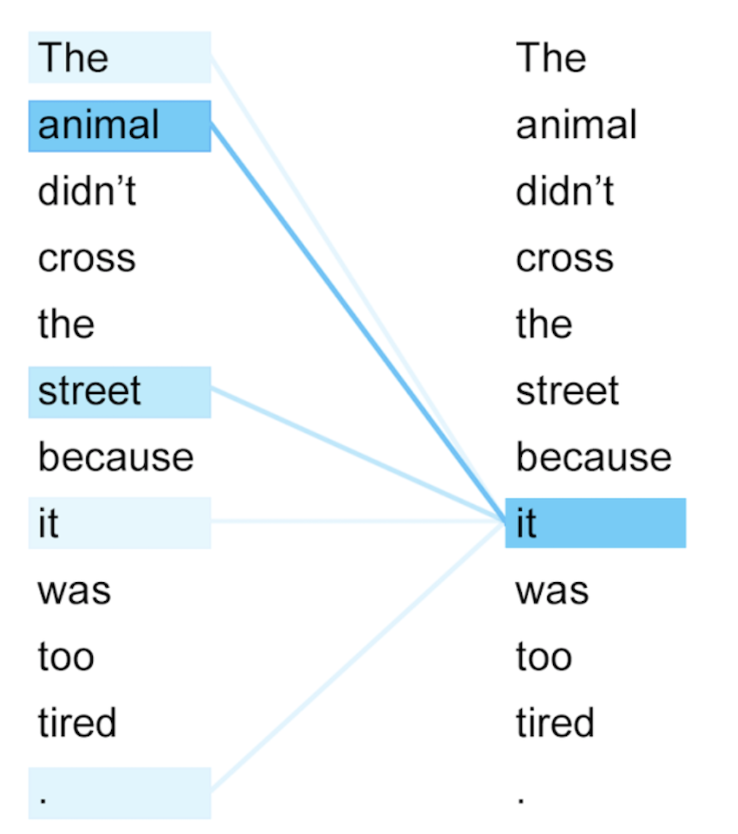

In the above example, you can see what a transformer model's attention layer thinks are the most relevant words to the word "it". Notice how this sequence of tokens is actually attending to itself (we will talk about this momentarily). As is seen above, the word "it" attends most to the word "animal", which makes sense given that the word "it" in this context is referring to the animal.

You can imagine that all our previous work converting words to vectors will be useful here: if a network understands the meaning of the word-representations we just formulated (embedding and positional encoding), it can create these interpretations and relations between words in the sentence, which might allow it to learn complex problems relating to sequence modelling.

The above is an example of self-attention, and it is the foundational building block of almost every recent NLP algorithm.

So how does it work?

## Learning Queries and Keys

Self-attention works by computing a sequence of attention computations against *itself*. That is, each element of a sequence computes attention against each  element of the sequence. We call one of these the *query* and the other the *key*.

You might be wondering: if one sequence is attending to itself, why do we give the two copies of the sequence different names?

The naming convention comes from the field of Information Retrieval, in which queries (e.g. a google search) are matched against various keys (e.g. a set of webpages), and then ranked and retrieved based off some score. This is analagous to attention, as we want to find what token in a sequence is most relevant to the current token we're processing.

In a Transformer, there is a dedicated set of weights meant to take input data and project it into queries, and a seperate set of weights dedicated to transforming the input data into keys.


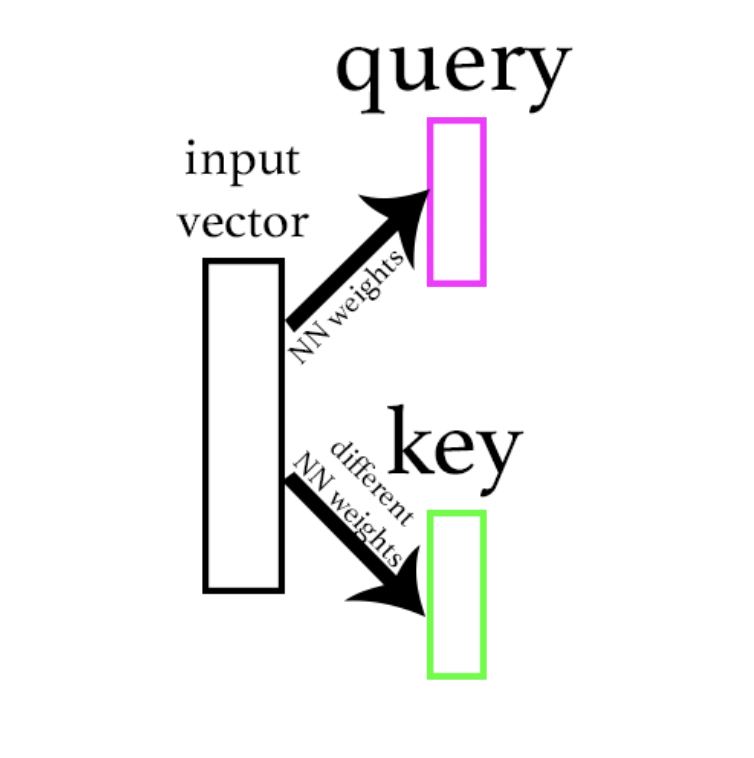

Above: an example of one input vector being turned into queries and keys. In reality, this conversion happens for an entire sequence of input vectors.

In [60]:
attn_dim = 128 # dimension of our keys and queries
input_dim = 512

q_layer = nn.Linear(input_dim, attn_dim) # linear projection layer from R512 -> R128, equivalent to dense/fully connected NN layer
k_layer = nn.Linear(input_dim, attn_dim) # linear projection layer from R512 -> R128, equivalent to dense/fully connected NN layer

queries = q_layer(PE_encoded.float()) # project our input tokens using query layer to get queries
keys = k_layer(PE_encoded.float()) # project our input tokens using key layer to get keys

attention = queries @ keys.T # compute attention between queries and keys; Note that we transpose keys so that we can use the matrix product to compute our dot products for us
attention.shape

torch.Size([1024, 1024])

In the above code block, we take a random sequence of vectors, use two different randomly initialized neural network layers to get our queries and keys, and then compute the attention between them. Note that the shape of our attention output is 1024x1024. Each row represents a different query, and each column represents a different key, so each cell `(i,j)` is the attention between query `i` and key `j`.

In theory, we can now train these two layers (`q_layer` and `k_layer`) to optimize some objective, and use gradient descent to modify the weights of this layer such that the output of the attention mechanism makes sense given real input data.

In [61]:
attention[0]

tensor([0.2600, 6.3605, 8.0307,  ..., 7.7464, 7.7196, 7.7565],
       grad_fn=<SelectBackward0>)

Above is the attention between query vector 0 and every key in our sequence of keys. 

## Values and Latent Representations

The main thing self-attention is used for is to learn useful *representations* of vectors. What this means is essentially using the neural network to take some input vector which has data we as humans can understand, and then turn it into a vector which has some sort of intrinsic meaning to the network. The vector space these intermediate vectors lie in is called a *latent space*, and often times we use attention to help construct new latent vectors.

So how does this happen?

Self-attention uses one more set of vectors: Values. These are vectors which are also learned, and they form a *basis* for all intermediate representations created by self-attention. In order to take an input vector and convert it into some latent vector, we take linear combinations of value vectors. 

What are the coefficents of these linear combinations? The attention values! We do some normalization by dividing by the square root of the attention dimension and with a function called `softmax` which ensures our attention values sum to 1, and then we construct a new vector for each token in the sequence, with the new vector at index `i` being equal to `normalized_attention[i] @ values[i]`

In [62]:
v_layer = nn.Linear(input_dim, attn_dim)

values = v_layer(PE_encoded.type(torch.float))
norm_attn = F.softmax(attention / np.sqrt(attn_dim))

new_tokens = norm_attn @ values

<ipython-input-62-6d32cfbf15b4>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  norm_attn = F.softmax(attention / np.sqrt(attn_dim))


In [63]:
print(new_tokens.shape) # should be 1024x128

torch.Size([1024, 128])


We use one more MLP / fully connected / linear layer to project our data back to its original input dimension and do something called *Layer Normalization* before and after this process, which essentially normalizes the data being passed through it to be between -1 and 1. 

In [64]:
attn_ln = nn.LayerNorm(attn_dim)

postprocess_mlp = nn.Linear(attn_dim, input_dim)
mlp_ln = nn.LayerNorm(input_dim)

ln = attn_ln(new_tokens)
mlp_tokens = postprocess_mlp(ln)
output = mlp_ln(mlp_tokens)

The last step is to add these latent representations with the original embedding. We call this a "residual connection".

In [65]:
output += PE_encoded

In [66]:
output.shape

torch.Size([1024, 512])

In [67]:
PE_encoded.shape

torch.Size([1024, 512])

As you can see, our output tokens match the dimension of our input tokens, meaning we've successfully used our queries, keys, and values to learn a new representation of our input. With random initialization, this output vector is essentially random noise, but a neural network can then define some training objective and train these different layers to learn queries, keys, and values, such that the resulting representations let it perform well on a given task.

## Multihead Attention

In Transformers, a form of self-attention called Mutlihead Attention is often used in place of traditional self-attention. It's pretty much exactly the same as the self-attention described above. The key difference is that self-attention is computed seperately and independently *a bunch* of times by different independent query, key, and value layers, and their results are all concatenated together.

In [68]:
def postprocess(new_tokens, attn_dim, input_dim):

  attn_ln = nn.LayerNorm(attn_dim)

  postprocess_mlp = nn.Linear(attn_dim, input_dim)
  mlp_ln = nn.LayerNorm(input_dim)

  ln = attn_ln(new_tokens)
  mlp_tokens = postprocess_mlp(ln)
  output = mlp_ln(mlp_tokens)

  return output

In [69]:
def self_attention(input_tokens, attn_dim, input_dim, n_tokens, mask=False, return_attn=False):
  q_layer = nn.Linear(input_dim, attn_dim) 
  k_layer = nn.Linear(input_dim, attn_dim) 

  queries = q_layer(input_tokens)
  keys = k_layer(input_tokens)

  self_attention = queries @ keys.T
  v_layer = nn.Linear(input_dim, attn_dim)

  values = v_layer(input_tokens)
  
  if mask: # we will discuss masking in the next section
    idx = torch.triu_indices(*self_attention.shape, offset=1)
    self_attention[idx[0], idx[1]] = -np.Inf

  norm_attn = F.softmax(self_attention / np.sqrt(attn_dim), dim=1)
  
  new_tokens = norm_attn @ values
  if return_attn:
    return new_tokens, norm_attn
  else:
    return new_tokens

In [70]:
input_dim = 512 # input dimension of our token vectors
num_heads = 4
attn_dim = 128//num_heads # num components in our keys and queries in each head 
num_tokens = 4 # num tokens in our sequence
random_tokens = torch.randn(num_tokens, input_dim)

head1 = self_attention(random_tokens, attn_dim, input_dim, num_tokens)
head2 = self_attention(random_tokens, attn_dim, input_dim, num_tokens)
head3 = self_attention(random_tokens, attn_dim, input_dim, num_tokens)
head4 = self_attention(random_tokens, attn_dim, input_dim, num_tokens)

In [71]:
head1.shape

torch.Size([4, 32])

In the above code snippet, I've aggregated the attention mechanism and the postprocessing into two separate functions, and computed attention into four `attention heads`. These all contain independent weights for their nn.Linear layers which project data into queries, keys, and values. Notice how instead of doing attention in the original 128 dimensions, they are doing their attention in only 32 dimensions. 

What we then do is take each head of this attention mechanism and *concatenate* it with each other head, meaning we append all the represented vectors end-to-end, i.e. head1 deals with the first 32 components of our final output vector, head2 deals with the next 32 components, and so on.

In [72]:
new_tokens = torch.concat([head1, head2, head3, head4], axis=1) # axis=1 means we concatenate column-wise

In [73]:
new_tokens.shape

torch.Size([4, 128])

We can now postprocess these like we usually would with regular self-attention.

In [74]:
output = postprocess(new_tokens, attn_dim=128, input_dim=512)

In [75]:
output.shape

torch.Size([4, 512])

The outputs tokens of this multihead attention are then added with the original input embeddings to create the final output of the Multihead Attention Layer.

In [76]:
output = output + random_tokens
output # the final result of our attention mechanism

tensor([[ 3.7876, -0.5592, -0.3261,  ..., -2.1729,  1.0962,  0.2372],
        [ 1.0463, -0.1190,  1.4000,  ..., -1.5782,  0.3277,  0.7728],
        [ 2.0017, -0.3453, -0.2280,  ..., -1.1446, -0.4809, -2.0558],
        [ 0.3878,  0.0953, -1.4781,  ..., -0.0101,  1.5315, -0.1343]],
       grad_fn=<AddBackward0>)

In [77]:
output.shape

torch.Size([4, 512])

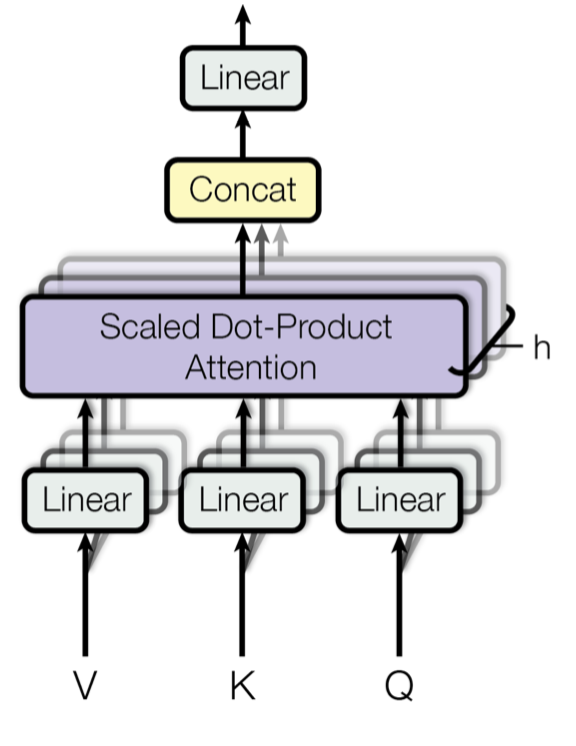

## If you understand everything up until this point, you understand the underlying mechanism behind a *multihead attention block*

In practice, Transformers compose dozens or even hundreds of these with each other (i.e., pass self-attended tokens into a new set of multihead attention layers over and over again), allowing for the networks to learn some very complex relationships. We honestly are still not 100% certain *why* this architecture is as powerful as it is, but what is certain is that the way attention is formulated allows these models to learn complex relationships between sequence elements.

# Part 4: Encoders and Decoders

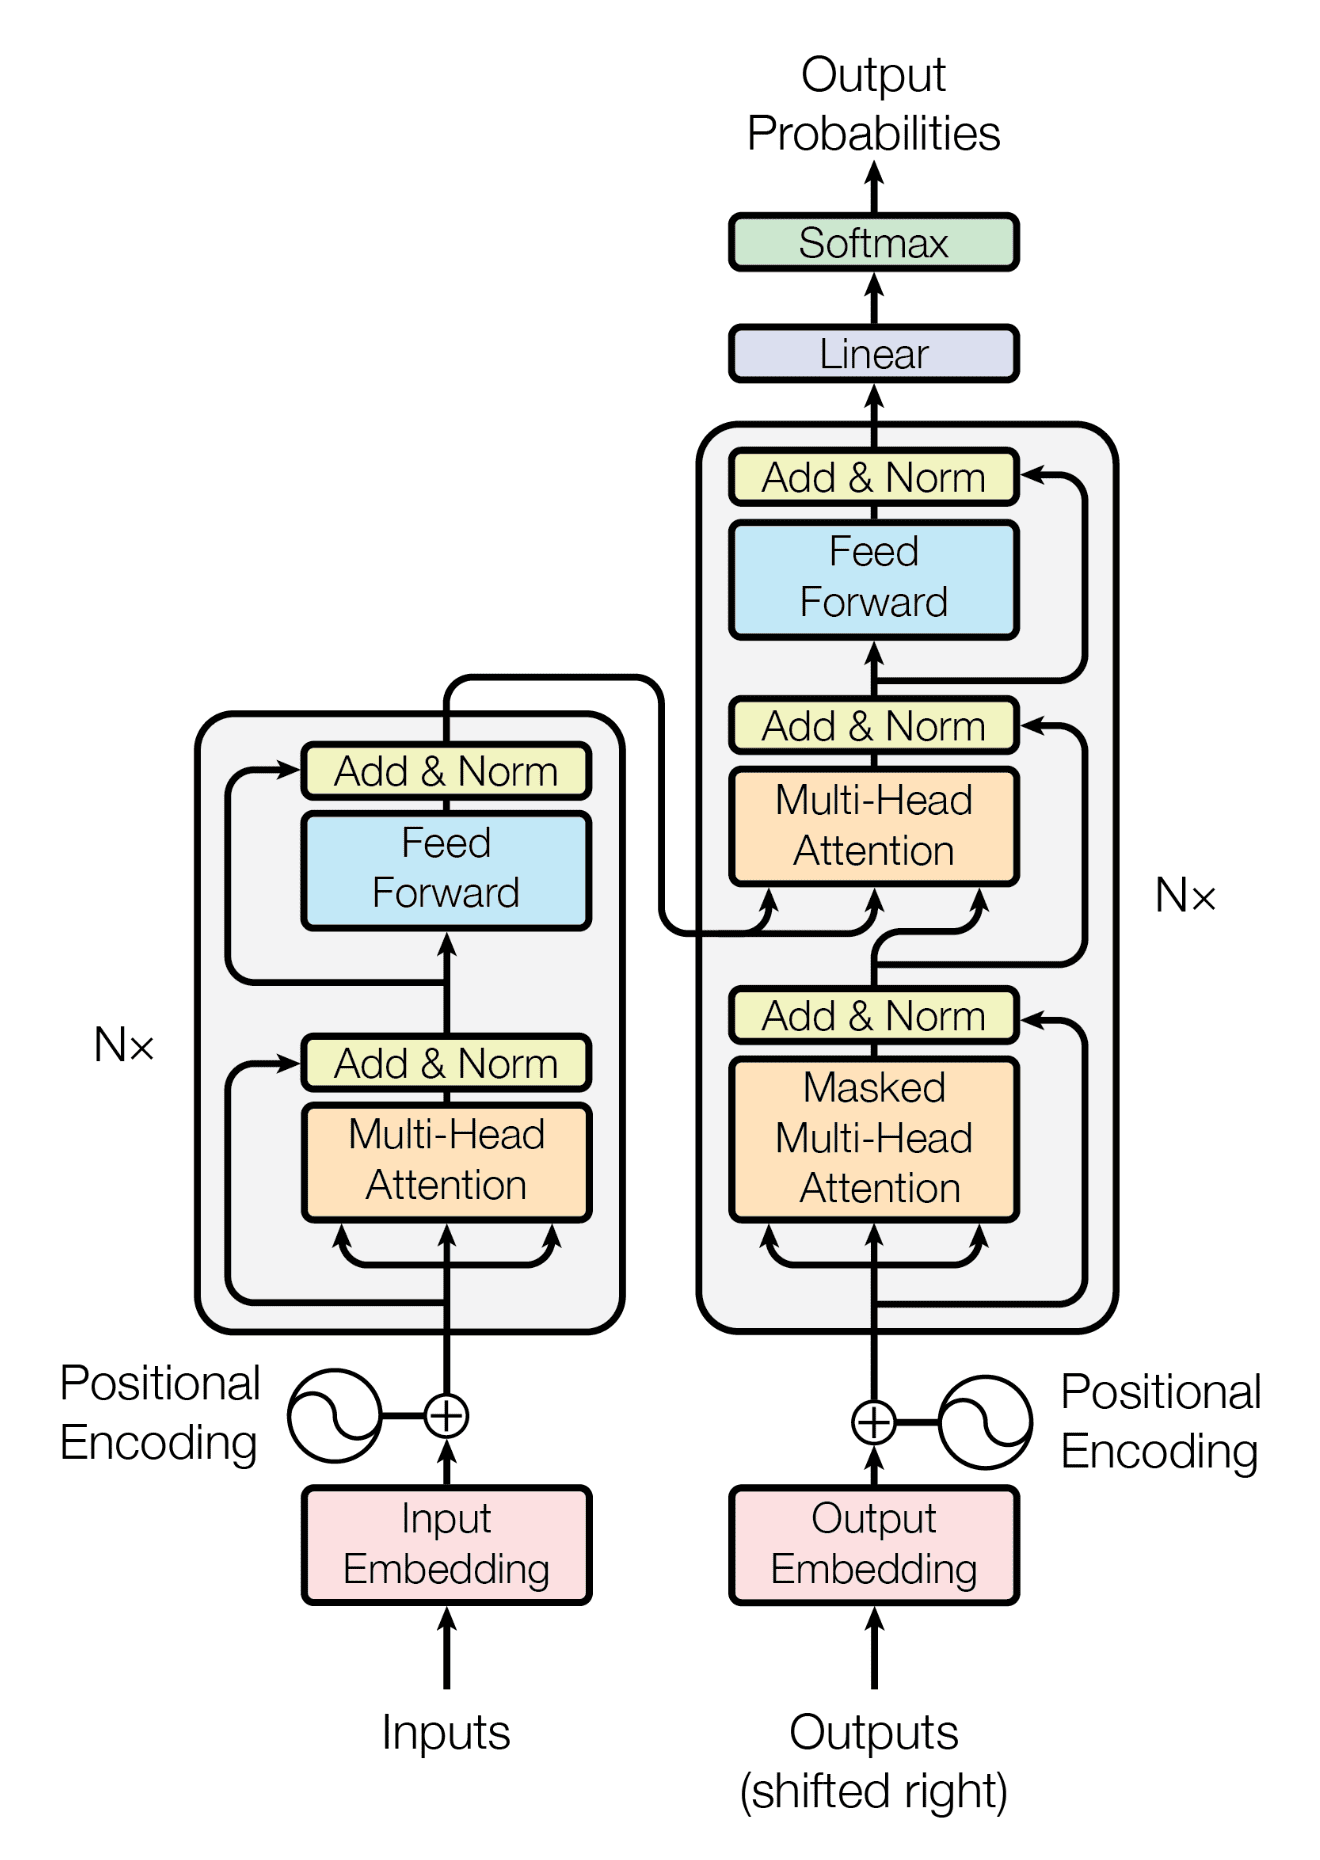

(sidenote: I hope some parts of this image make sense by now!)

Transformers are kind of an ambiguous term because they usually refer to 1 of 2 different architectures: encoders and decoders. Transformer Encoders try to take input sequences and learn some sort of useful vector representations from them (models like BERT do this). In contrast, Transformer Decoder models try to take input sequences and use self-attention to *decode* some output sequence, i.e. use self-attention to predict the next word in a sequence (ala GPT-3). 

The original Transformers paper actually used *both* an Encoder and Decoder to do sequence-to-sequence prediction (think of translating English to another language), but most big Language Models generally tend to use one or the other to achieve their desired tasks. 

## Encoders

Transformer Encoders are Neural Networks that map a sequnce of tokens to a different, self-attended sequence of tokens. The self-attended sequence of tokens can then be used for some training task.

To illustrate this in greater detail, we examine a Transformer model called BERT:

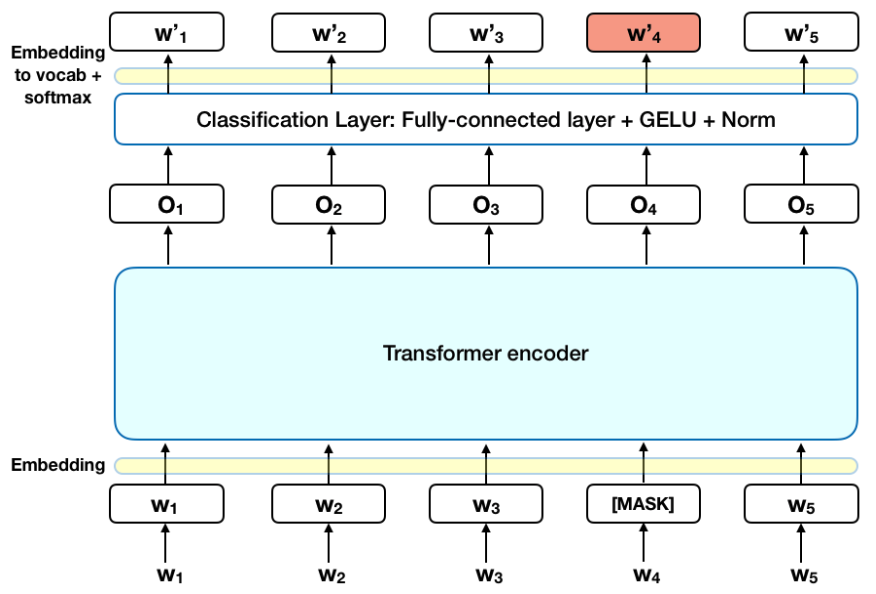

### Imagine I gave you a sentence but hid one of the words from you. Do you think you'd be able to predict what that word was?

Try this sentence:

The quick brown fox ___ over the lazy dog.

It's pretty easy for us to determine that the missing word is "jumps", but it could also reasonably be "steps." There are plenty of possible reasonable words that fill in the blank, but note that they're all context dependent.

This missing-word-prediction is exactly what BERT is trained to do. BERT is given a bunch of real English sentences, and then a *mask* is introduced which obscures a random word in the sentence. It's BERT's job to accurately predict what the word was. 

How it does this is by assigning a *probability* to each word in its vocabulary. BERT predicts a probability for each token ID, and then this is compared with the actual word that was taken out. BERT is then trained to make that probability distribution match what it sees in its training data.

It does this using JUST a sequence of self-attended tokens.

In [78]:
sentence = '[START] the quick brown fox [MASK] over the lazy dog [END]'

my_vocab = ['hi', 'hello', 'the', 'quick', 'mean', 'brown', 'fox', 'quick', 'jumps', 'over', 'lazy', 'dog', 'very', 'nice', '[START]', '[END]', '[MASK]']
ids = {my_vocab[i]:i for i in range(len(my_vocab))}

mask_idx = 5

tokenized = torch.tensor([ids[i] for i in sentence.split(' ')])
padded = torch.zeros(seq_len)
padded[0:len(tokenized)] = tokenized

padded = padded.type(torch.int)

print(f'Padded sequence: {padded}')

Padded sequence: tensor([14,  2,  7,  ...,  0,  0,  0], dtype=torch.int32)


In [79]:
embedded = emb(padded)
pe = embedded + good_positional_encodings

pe = pe.type(torch.float32)
attended = self_attention(pe, attn_dim = 128, input_dim=512, n_tokens=1024)
out = postprocess(attended, attn_dim=128, input_dim=512)

vocab_size = len(my_vocab)
last_linear = nn.Linear(input_dim, vocab_size-1) # creates a linear layer to map from our attention output size to vocab size-1. 
# Note that we map to vocab_size -1 to make sure the network can't predict [MASK] as a token.
probs = F.softmax(last_linear(out), dim=1)

print(f'Probabilities: {probs}')

Probabilities: tensor([[0.0408, 0.0587, 0.0185,  ..., 0.0308, 0.0451, 0.0466],
        [0.0409, 0.0587, 0.0185,  ..., 0.0308, 0.0451, 0.0466],
        [0.0409, 0.0588, 0.0185,  ..., 0.0308, 0.0452, 0.0466],
        ...,
        [0.0409, 0.0587, 0.0185,  ..., 0.0307, 0.0451, 0.0466],
        [0.0409, 0.0587, 0.0185,  ..., 0.0307, 0.0451, 0.0466],
        [0.0409, 0.0587, 0.0185,  ..., 0.0307, 0.0451, 0.0466]],
       grad_fn=<SoftmaxBackward0>)


The above probability matrix gives this network's predicted probability distribution of what word each token is. Each row of this matrix is a vector of `vocab_size` length. The first vector contains the model's predicted probability for every token ID whether or not that ID is the first token in the sequence. The 2nd entry corresponds to the 2nd token, and so on. The probability distribution for the first and second token is already *given* to us, so the model's prediction for those tokens doesn't matter that much. But what we *do* care about is the model's predictions for the masked token.

The computed results above are clearly for exemplary purpose, and don't reflect a trained model, since we're using randomly initialized weights. However, for the sake of the example, let's examine the predicted probabilities for the masked token.

In [80]:
mask_probs = probs[mask_idx]
mask_probs

tensor([0.0409, 0.0587, 0.0185, 0.1193, 0.0232, 0.0985, 0.0479, 0.0220, 0.0213,
        0.1062, 0.0825, 0.1293, 0.1092, 0.0308, 0.0452, 0.0466],
       grad_fn=<SelectBackward0>)

These are the predicted probabilities for each word in our small toy vocabulary. We interpret this prediction as follows: the first word ('hi') has a `mask_probs[0]` odds, the second word ('hello') has `mask_probs[1]` odds, and so on.

To get the network's prediction of the correct word, we can simply choose the word with highest probability.

In [81]:
best_idx = torch.argmax(mask_probs) # finds the index of max probability
best_idx

tensor(11)

In [82]:
print(f'Network prediction for masked token: "{my_vocab[best_idx]}"')

Network prediction for masked token: "dog"


One question that naturally arises is: how do we train this thing? What is our loss function here?

In [83]:
true_label = torch.tensor([0 if x is not "jumps" else 1 for x in my_vocab[0:-1]]).type(torch.float)
true_label

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-83-b1f711c81ba8>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  true_label = torch.tensor([0 if x is not "jumps" else 1 for x in my_vocab[0:-1]]).type(torch.float)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

Ideally, our network should predict the correct word with a probability of 1.0, and every other word should have probability 0. 

We can now use a function called Cross-Entropy to determine how "off" our network's prediction was. Cross-Entropy is a function from information theory which essentially tells us how two different distributions differ from each other. In our specific case, since our target distribution is binary (i.e. a word should be assigned either a 0 or 1.0 probability in the perfect scenario), we use a variant called Binary Cross Entropy. This function is differentiable, which allows us to update the weights of our encoder using gradient descent to make our predicted distribution closer to the target distribution.

In [99]:
F.binary_cross_entropy_with_logits(mask_probs, true_label)

tensor(0.7237, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [100]:
true_label.shape

torch.Size([16])

As you can see, with a lot of examples, we can now formulate a loss function, and using this self-attention mechanism combined with a linear layer, we can train this network to achieve the task of predicting the missing word.

A benefit of this is that once we've trained our model, we can use these self-attended representations to do a variety of other tasks. Pretrained BERT encodings are super commonly used in tons of natural language tasks. For those who are familiar, this is one way of generating "word embeddings", a technique to map words to vectors with important semantic information. BERT word embeddings are simply just their self-attended representations.

## Decoders and Masking

In contrast to models like BERT which try to learn useful vector representations of language, Transformer Decoders leverage multihead attention to *generate* new tokens given some context.

Think of the previous example sentence.

If I gave you: "The quick brown fox" and asked you what the most likely next word is, you'd probably say "jumps." This is the task of decoder transformers: predicting the most likely next word in a given sequence.

However, our traditional formulation of self-attention has a caveat here. When we're trying to predict the next *word* in a sequence, it's weird to have certain tokens attend to tokens that appear after it.

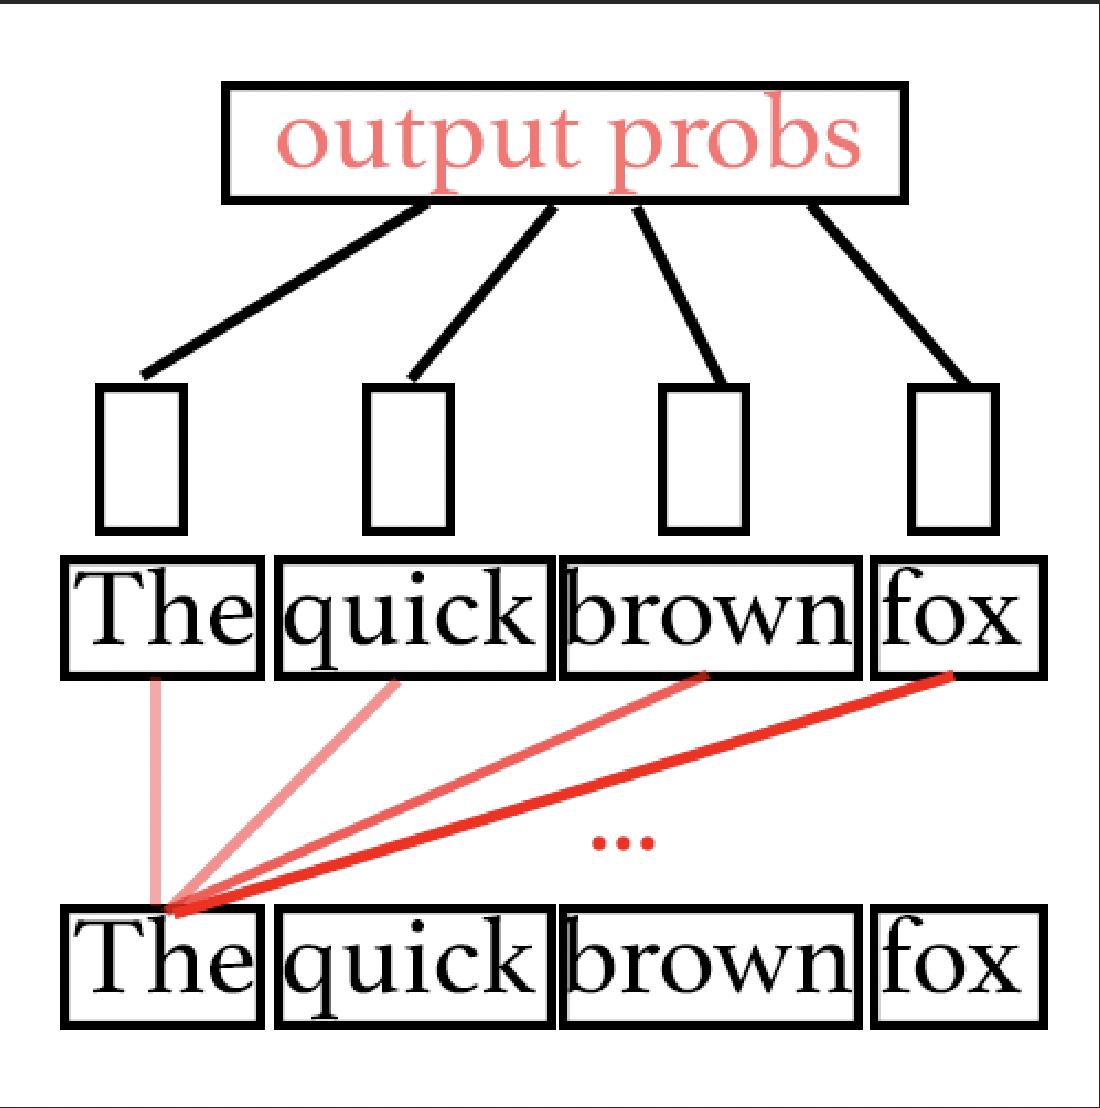

For next-word prediction, the above formulation is kind of "cheating" in a sense, since when we're at the word "The", we don't know that the words quick, brown, or fox have actually occured yet. When we actually use this model in a real-world setting, it won't be able to attend to tokens it hasn't seen yet. For this reason, people often times *mask out* all future tokens in the attention representation. I.e., token 1 can only attend to token 1, token 2 can attend to tokens 1 and 2, etc.

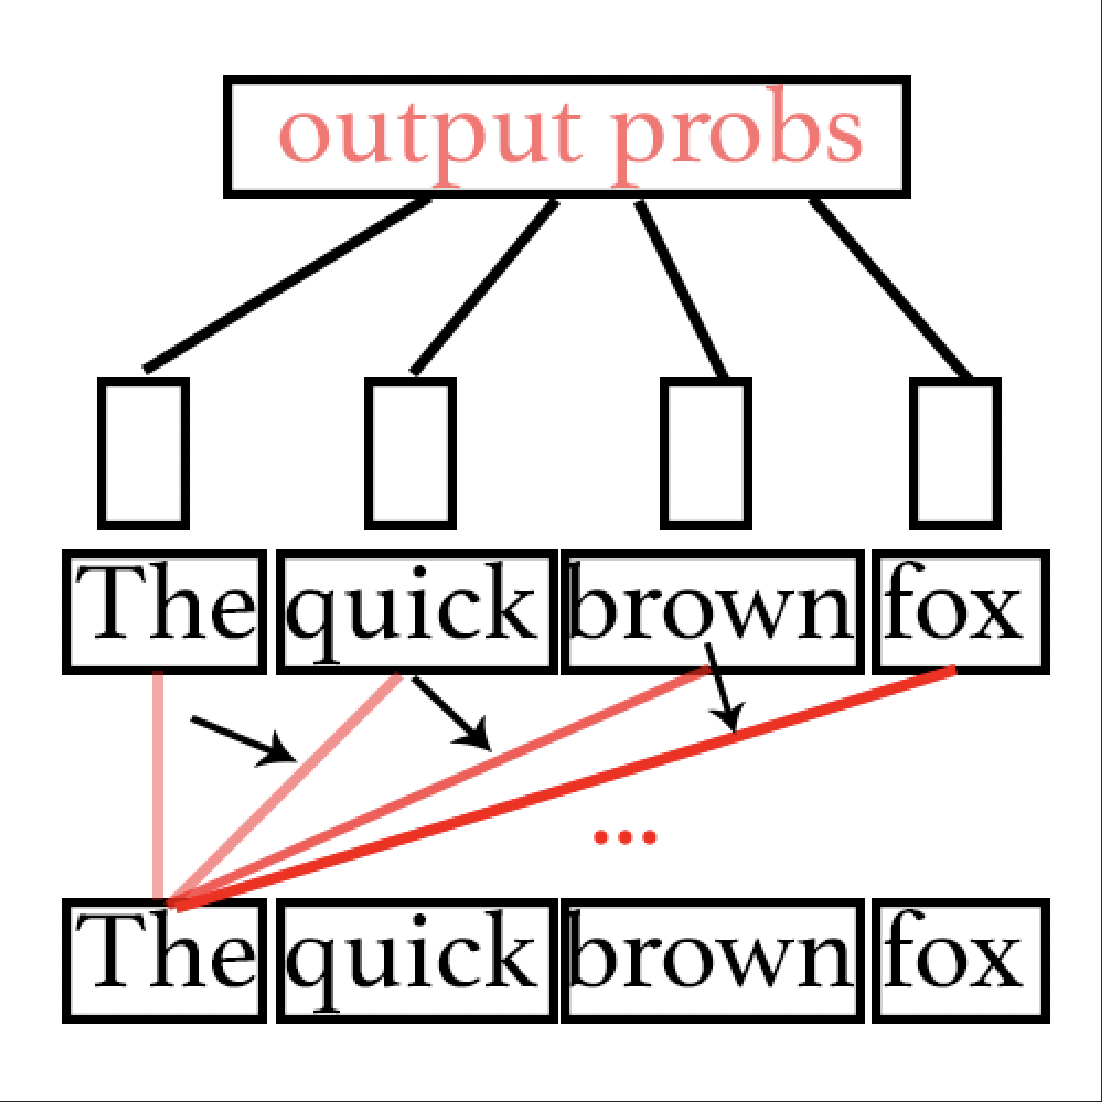

Because of this, the final token in our sequence is the only token that actually gets to attend to every other token in our sequence. For that reason, in transformer decoder models, we often times only use the last token in a given sequence in order to get an accurate representation of the sequence as a whole in terms of just one vector. This vector can then be transformed via. a feedforward layer + softmax to predict next-word probability.

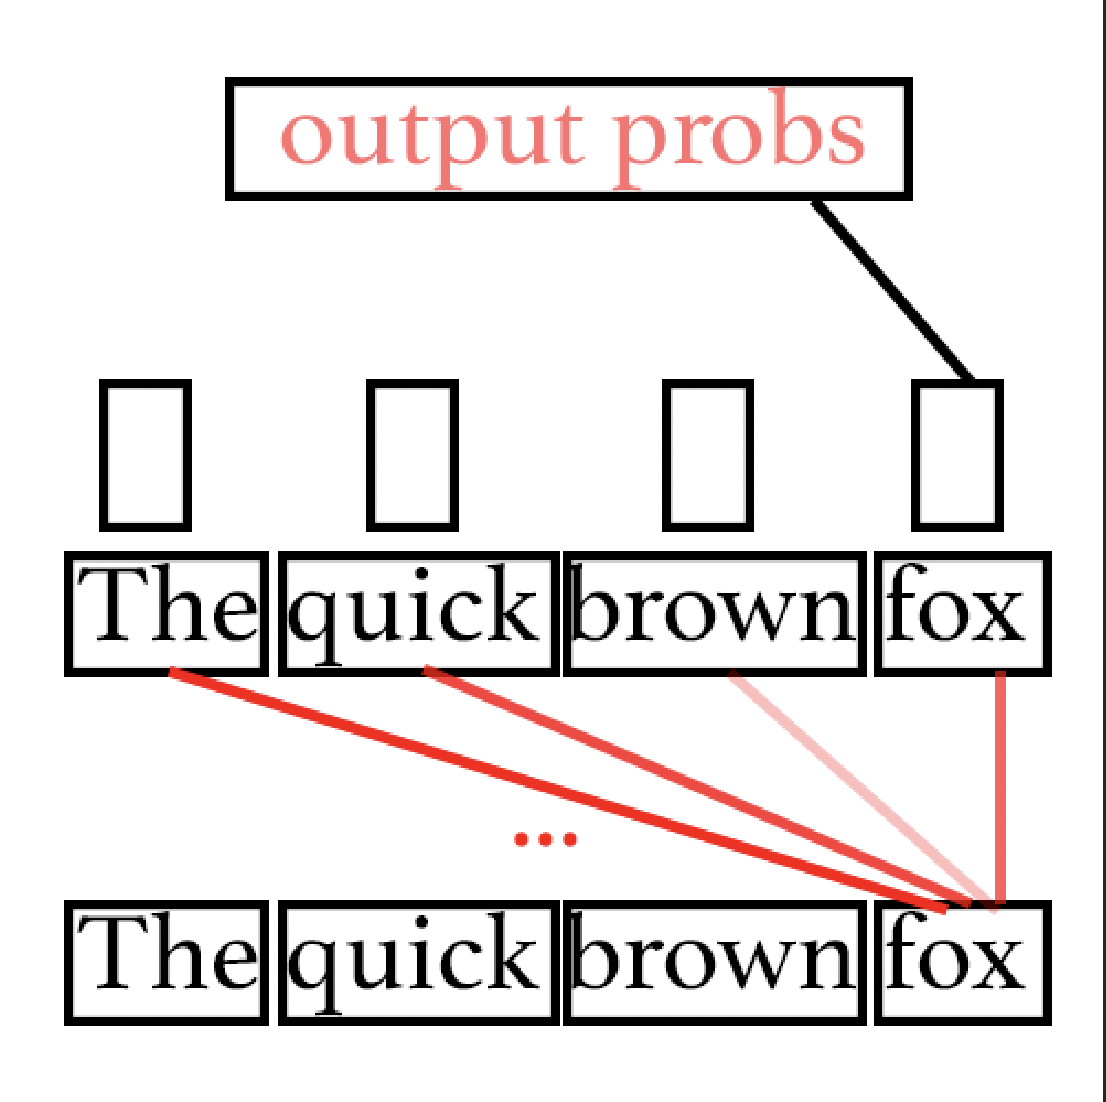

In [101]:
sentence = '[START] the quick brown fox over the lazy dog [END]'

tokenized = torch.tensor([ids[i] for i in sentence.split(' ')])
padded = torch.zeros(seq_len)
padded[0:len(tokenized)] = tokenized

padded = padded.type(torch.int)

print(f'Padded sequence: {padded}')

Padded sequence: tensor([14,  2,  7,  ...,  0,  0,  0], dtype=torch.int32)


In [102]:
embedded = emb(padded)
pe = embedded + good_positional_encodings

pe = pe.type(torch.float32)
attended, attn_mat = self_attention(pe, attn_dim = 128, input_dim=512, n_tokens=1024, mask=True, return_attn=True)
out = postprocess(attended, attn_dim=128, input_dim=512)[-1] # last element in our masked self attention sequence

vocab_size = len(my_vocab)
last_linear = nn.Linear(input_dim, vocab_size) #
# Note that we add the -1 to make sure the network can't predict [MASK] as a token.
probs = F.softmax(last_linear(out))

print(f'Probabilities: {probs}')

Probabilities: tensor([0.0833, 0.0343, 0.0569, 0.0536, 0.0610, 0.0895, 0.0878, 0.0504, 0.0541,
        0.0518, 0.0353, 0.0765, 0.1693, 0.0188, 0.0322, 0.0095, 0.0356],
       grad_fn=<SoftmaxBackward0>)


<ipython-input-102-b094c13d82bb>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(last_linear(out))


In [103]:
best_idx = torch.argmax(mask_probs) # finds the index of max probability
print(f'Model prediction: {my_vocab[best_idx]}')

Model prediction: dog


In [104]:
attn_mat

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.1876e-01, 4.8124e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.7096e-01, 3.1429e-01, 4.1475e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.5861e-03, 9.2822e-04, 7.2698e-04,  ..., 9.4400e-04, 0.0000e+00,
         0.0000e+00],
        [1.6058e-03, 9.2922e-04, 7.3815e-04,  ..., 9.4420e-04, 9.4465e-04,
         0.0000e+00],
        [1.5546e-03, 9.1966e-04, 7.3803e-04,  ..., 9.4359e-04, 9.4341e-04,
         9.7458e-04]], grad_fn=<SoftmaxBackward0>)

Above is the attention matrix for our prediction. As you can see, the distribution of attention for the first token is just attending to itself, with attention of 0 to every other token in the sequence due to masking. For the second token, you can see that we now have two nonzero attention values, and so on.

Just like with the Transformer Encoder, this can be trained to optimize some training objective. And when these models are used in inference, they predict a next word and then feed the new sequence of words back into the model as input. The sequence terminates either when the model reaches its maximum sequence length or the model predicts the [END] token.

## Bidirectional vs. Masked Attention

As a small terminology aside, there's two forms of attention: bidirectional attention and masked (unidirectional) attention. Bidirectional attention allows tokens to attend to tokens in the future of the sequence (i.e. tokens can attend both forwards and backwards in the sequence), whereas masked attention only allows tokens to attend backwards in time. It's good to know when bidirectional attention makes sense (like in BERT) and when unidirectional attention makes sense.

# Conclusion

## Overall Advantages of Transformers

### Scale

One metric that's often used to assess *architectures* is how well they *scale*. That is to say, if I have some Neural Network architecture and I throw a bunch more layers, data, and computational power at it, will my new network improve considerably?

For a lot of prior architectures, this was not necessarily the case. But Transformers have proven themselves to be the kings of scaling. We can throw 500 billion parameters, petabytes of text data, and tens of millions of dollars worth of servers at a Transformer model and it will be worth it.


### Parallelization

One advantage of Multihead Attention over other architectures like RNNs is that in practice, we can compute the *forward pass* of our a Transformer much faster than, say, an RNN, thanks to parallelization. Consider the case of a Trasnformer running on a 8 GPUs. We can assign each GPU one of the heads of our multihead attention, and since each individual attention head computation is far less complex than non multihead attention (i.e. matmul of lower dimension matrices), each GPU will compute their head of attention much faster than if we computed traditional self-attention on one GPU. In contrast, RNNs and other time-series models  can't parallelize in the same fashion. 

This efficient computation of a Transformer's forward pass allows us to scale them much easier than other models: the computation strain from scaling up a model is greatly alleviated by the ability to parallelize the attention computation efficiently.

## A Big Drawback: Sequence Length

One of the biggest drawbacks for Transformers is their sequence / context length. Recall how self-attention involves taking a dot product between every element of a sequence and every other element of a sequence. For a sequence of 10 tokens, this is 10x10 dot products, or 100 total. For a sequence of 1000 tokens, this is 1000x1000 dot products, or 1,000,000 total. In general, the *computational complexity* of attention is O(n^2), where n is the length of your input sequence. 

This is a big problem. For sequences that are much longer, say 10,000 or 100,000 tokens, the number of computations involved in just 1 attention head will balloon much faster than is computationally tractable. As such, sequence length is generally limited to be quite short, which means transformers have a difficult time modeling long sequences. For example, GPT-3 would not be able to read an entire book as a prompt and answer some question about the book, since a book might have millions of tokens, and GPT-3's context window is limited to just 1024 tokens or so. 

Lots of current research is devoted to making the attention mechanism more efficient so that perhaps we'll be able to use transformers for long-sequence modelling, but this is still an open problem.

## The End!

I hope this notebook has been a good primer on how Transformers work! There are probably minor details I missed, but I tried to ensure this covers as much of the necessary material as possible.

# Appendix: Torch Implementation of a Trasnformer Encoder

For those with lots of experience with PyTorch, below I've included my own implmenetation of a Transformer Encoder (just the architecture/forward pass) using all the concepts introduced in this notebook. You might find this more useful than the toy code examples above.

In [ ]:
from torch.nn.init import xavier_uniform_

In [ ]:
class TrasnformerEncoder(nn.Module):
  '''
  End to end Transformer Encoder in PyTorch.
  '''
  def __init__(
      self,
      input_dim = 512,
      seq_len = 1024,
      attn_dim = 128,
      num_heads = 8,
      num_blocks = 4,
      vocab_size = 50000
  ):
    super().__init__()

    self.positional_encoder = PositionalEncoder(seq_len, input_dim)
    self.input_dim = input_dim
    self.seq_len = seq_len
    self.attn_dim = attn_dim
    self.num_heads = num_heads
    self.num_blocks = num_blocks
    self.vocab_size = vocab_size

    self.initial_embed = nn.Embedding(vocab_size, input_dim)
    self.blocks = nn.ModuleList([
        TransformerEncoderLayer(self.input_dim, self.seq_len, self.attn_dim, self.num_heads)
        for _ in range(num_blocks)
    ])

    self._reset_parameters()

  def _reset_parameters(self):
        """Initiate parameters in the transformer model. Taken from PyTorch Transformer impl"""
        for p in self.blocks.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

  def forward(self, x):
    emb = self.initial_embed(x)
    emb = self.positional_encoder(emb)

    for block in self.blocks:
      emb = block(emb)

    return emb

In [ ]:
class TransformerEncoderLayer(nn.Module):
  '''
  Layer object to compute (bidirectional) multihead attention on inputs
  '''
  def __init__(
      self,
      input_dim = 512,
      seq_len = 1024,
      attn_dim = 128,
      num_heads = 8,
  ):

    super().__init__()

    self.input_dim = input_dim
    self.seq_len = seq_len
    self.attn_dim = attn_dim
    self.num_heads = num_heads

    self.head_attn_dim = attn_dim // num_heads

    self.query_layers = [
        nn.Linear(self.input_dim, self.head_attn_dim)
        for head in range(num_heads)
    ]

    self.key_layers = [
        nn.Linear(self.input_dim, self.head_attn_dim)
        for head in range(num_heads)
    ]

    self.value_layers = [
        nn.Linear(self.input_dim, self.head_attn_dim)
        for head in range(num_heads)
    ]

    self.ln = nn.LayerNorm(attn_dim)
    self.out_proj = nn.Linear(attn_dim, input_dim)

  def get_qkv(self, x, head):
    q = self.query_layers[head](x)
    k = self.key_layers[head](x)
    v = self.value_layers[head](x)

    return q, k, v

  def attention(self, x):
    out_tokens = []
    for head in range(self.num_heads):
      q, k, v = self.get_qkv(x, head)
      attention = q @ torch.transpose(k, 1, 2) # since our tensors are 3 dimensional, we have to transpose axis 1 and axis 2, i.e. we cant do k.T
      norm_attention = F.softmax(attention / np.sqrt(self.head_attn_dim))

      new_tokens = norm_attention @ v
      out_tokens.append(new_tokens)

    return torch.concat(out_tokens, axis=-1) # again, since our tensors are 3 dimensional, we have to concat by the last axis, not axis=1

  def forward(self, x):
    a = self.attention(x)
    a = self.ln(a)
    a = self.out_proj(a)
    
    return a + x

  

In [ ]:
class PositionalEncoder(nn.Module):
  def __init__(
      self,
      seq_len = 1024,
      input_dim = 512,
  ):
    super().__init__()

    self.seq_len = seq_len
    self.input_dim = input_dim

    self.positional_encodings = self.create_positional_encodings(self.seq_len, self.input_dim)

  def pe(self, pos, idx, dim):
    if idx % 2 == 0:
      return np.sin(
          pos / (
            np.power(10000, idx/dim)
          )
      )
    else:
      return np.cos(
          pos / (
            np.power(10000, (idx-1)/dim)
          )
      )

  def create_positional_encodings(self, seq_len, input_dim):
    sequence = torch.zeros(size=(seq_len, input_dim))
    for pos in range(seq_len):
      for idx in range(input_dim):
        sequence[pos, idx] = torch.tensor(self.pe(pos, idx, input_dim))

    return sequence

  def forward(self, x):
    return x + self.positional_encodings


In [ ]:
x = TrasnformerEncoder()

In [ ]:
batch_size = 16
seq_len = 1024
vocab_size = 50000
random_tokens = torch.randint(0, vocab_size, size=(batch_size, seq_len)) # random integer tokens

In [ ]:
random_tokens.shape # should be 16 x 1024

torch.Size([16, 1024])

In [ ]:
random_tokens[0] # one random sequence of tokens

tensor([26332, 21776,   327,  ..., 37820, 34492,  8721])

In [ ]:
model_output = x(random_tokens) # do self-attention forward pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
model_output[0] # self-attended version of that same sequence of random tokens (with random weight initialization)

tensor([[-2.4487,  1.9094, -0.2924,  ...,  2.5695,  1.3933,  3.6633],
        [ 0.7690,  2.0697,  0.0057,  ...,  1.9088,  0.3362,  1.8668],
        [ 1.6272, -1.3977,  0.8228,  ...,  4.0540,  2.0836,  2.4632],
        ...,
        [-1.5075, -0.3355, -3.1573,  ...,  1.1355,  0.2788,  1.4414],
        [-3.3136, -1.3727, -1.4182,  ...,  0.7772, -1.6893,  3.5716],
        [-3.1930,  0.2690,  2.0022,  ...,  4.7537, -1.3497,  2.3254]],
       grad_fn=<SelectBackward0>)

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(x)

25865216

Our transformer encoder has 25,865,216 trainable parameters (weights). This function was snatched from [this discussion thread](https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325)